## Intel Image Classification Challenge

## Different models have been used and are organized by their performance.

## DenseNet201 gives us nearly 90% accuracy on Training and 90% accuracy on validation


In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [18]:
import glob
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [19]:
import os
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter
import cv2
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from sklearn.metrics import fbeta_score


In [20]:
glob.glob('../input/intel-image-classification/seg_train/seg_train/*')

['../input/intel-image-classification/seg_train/seg_train/mountain',
 '../input/intel-image-classification/seg_train/seg_train/street',
 '../input/intel-image-classification/seg_train/seg_train/buildings',
 '../input/intel-image-classification/seg_train/seg_train/sea',
 '../input/intel-image-classification/seg_train/seg_train/forest',
 '../input/intel-image-classification/seg_train/seg_train/glacier']

From the output of glob, it is clear that there are 6 classes, each containing images of their folder name.



In [21]:
TrainImage="../input/intel-image-classification/seg_train/seg_train"
TestImage="../input/intel-image-classification/seg_train/seg_test"
Seaimages = os.listdir(TrainImage + "/sea")
Forestimages = os.listdir(TrainImage + "/forest")
Mountimages = os.listdir(TrainImage + "/mountain")
Glacierimages = os.listdir(TrainImage + "/glacier")
Buildingsimages = os.listdir(TrainImage + "/buildings")
Streetimages = os.listdir(TrainImage + "/street")

Great! let us see how many images are there for the 6 classes.

The dataset seems to pretty balanced as there almost similar number of images in all the classes.


In [22]:
print(len(Seaimages), len(Forestimages), len(Mountimages), len(Glacierimages), len(Buildingsimages), len(Streetimages))
NUM_TRAINING_IMAGES = len(Seaimages)+ len(Forestimages)+ len(Mountimages)+ len(Glacierimages)+ len(Buildingsimages)+ len(Streetimages)
print(NUM_TRAINING_IMAGES)

2274 2271 2512 2404 2191 2382
14034


There are 14034 Training images and 3000 Test images

In [23]:
image_size = 128 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '../input/intel-image-classification'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/seg_train/seg_train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/seg_test/seg_test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [24]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)

train batch  (16, 128, 128, 3)
test batch  (16, 128, 128, 3)


In [25]:
training_set.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [26]:
labels = ['buildings', 'forest','glacier','mountain','sea','street']

In [27]:
sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

A sample of the images:

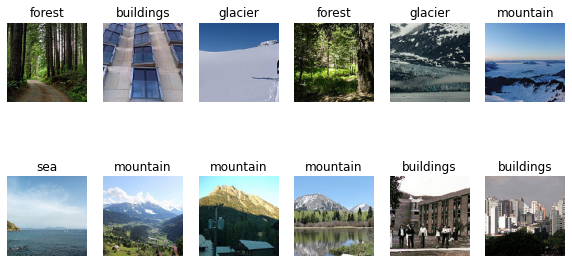

In [28]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 6, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [29]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [30]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [31]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [32]:
#label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [33]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 4.9 MB/s  eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Defining the Learning Rate Annealer and Early Stopping callbacks

In [34]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [35]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.1465084436330444,
 1: 1.1061206516952884,
 2: 1.0449251247920133,
 3: 1.0,
 4: 1.1046613896218118,
 5: 1.054575986565911}

In [36]:
# default input shapes 
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)

82526208/82524592 [==============================] - 4s 0us/step
(None, 224, 224, 3)
268320768/268317848 [==============================] - 5s 0us/step
(None, 600, 600, 3)
553467904/553467096 [==============================] - 19s 0us/step
(None, 224, 224, 3)


In [37]:
# EXTRA In case you want to save the h5 file 

checkpoint = ModelCheckpoint(
    'Densenet201_model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [38]:
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Embedding, Reshape, Concatenate, SeparableConv2D
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

inputs = Input(shape=(128, 128, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=6, activation='softmax')(x)

# Creating model and compiling
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='RMSprop', loss=categorical_smooth_loss, metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [39]:
history = model.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)

Epoch 1/30
878/878 [==============================] - 159s 181ms/step - loss: 1.3232 - accuracy: 0.5388 - val_loss: 1.2967 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 2/30
878/878 [==============================] - 76s 86ms/step - loss: 1.1629 - accuracy: 0.6511 - val_loss: 2.6117 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 3/30
878/878 [==============================] - 76s 87ms/step - loss: 1.1155 - accuracy: 0.6848 - val_loss: 10.1660 - val_accuracy: 0.1580 - lr: 0.0010
Epoch 4/30
878/878 [==============================] - 76s 86ms/step - loss: 1.0601 - accuracy: 0.7143 - val_loss: 1.3135 - val_accuracy: 0.6213 - lr: 0.0010
Epoch 5/30
878/878 [==============================] - ETA: 0s - loss: 1.0328 - accuracy: 0.7313
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
878/878 [==============================] - 76s 87ms/step - loss: 1.0328 - accuracy: 0.7313 - val_loss: 1.6746 - val_accuracy: 0.4903 - lr: 0.0010
Epoch 6/30
878/878 [===========================

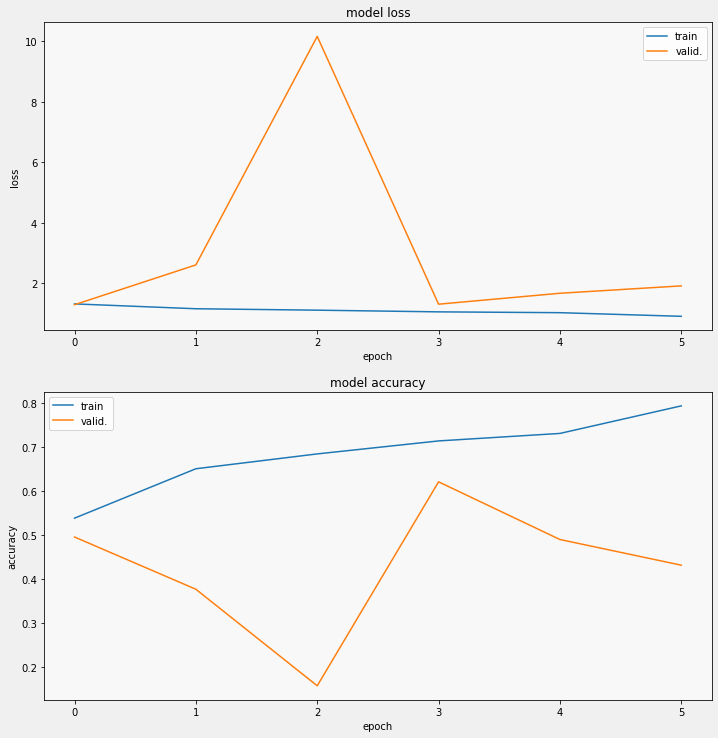

In [40]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

### We observe that the training and validation accuracy is around 0.80 and let's improve the model

### If we use a pre-trained model which is trained on a data which is similar to the problem we are trying to solve, the process is called Transfer Learning. There are various models available

### The accuracy can be improved further depending on the architecture and a number of parameters, but here we are limiting it to focus on the fine-tuning part hence we run it for a small number of epochs

# *VGG19*



VGG19 is a pre trained model, but however to use it for our problem, we have to modify a few layers.

optimizer: RMSprop

loss: categorical_crossentropy

Note: We are training the last layer of the VGG19, and then adding a few layers. Finally we use 6 neurons, since we have 6 classes that we wish to classify. The last layer uses softmax optimizer.

In [41]:
from tensorflow.keras import applications
from tensorflow.keras import models, layers
from keras import Sequential 

pretrained_model = applications.VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(128, 128, 3)
)

for layer in pretrained_model.layers[:-1]:
  layer.trainable = False

pretrained_model.summary()

#pretrained_model.trainable = False

model = models.Sequential()

model.add(pretrained_model)

model.add(layers.Flatten())

model.add(layers.Dropout(0.25))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax"))

80142336/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [42]:
# VGG19
model.compile(optimizer='RMSprop',loss='categorical_crossentropy',metrics=['accuracy'])
history_densenet = model.fit_generator(training_set, validation_data=testing_set, callbacks=[checkpoint,lr_reduce, es_callback], epochs=20)

Epoch 1/20
878/878 [==============================] - 77s 88ms/step - loss: 0.9578 - accuracy: 0.7071 - val_loss: 0.4825 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 2/20
878/878 [==============================] - 77s 88ms/step - loss: 0.6743 - accuracy: 0.7734 - val_loss: 0.4894 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 3/20
878/878 [==============================] - 75s 85ms/step - loss: 0.6480 - accuracy: 0.7919 - val_loss: 0.4829 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 4/20
878/878 [==============================] - 76s 86ms/step - loss: 0.6622 - accuracy: 0.7985 - val_loss: 0.5191 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 5/20
878/878 [==============================] - 76s 87ms/step - loss: 0.6781 - accuracy: 0.7946 - val_loss: 0.5105 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 6/20
878/878 [==============================] - 76s 87ms/step - loss: 0.6812 - accuracy: 0.7982 - val_loss: 0.5744 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 00006: early stopping


This is a good improvement, although it trained only for a few epoch reaching a validation accuracy of 0.86

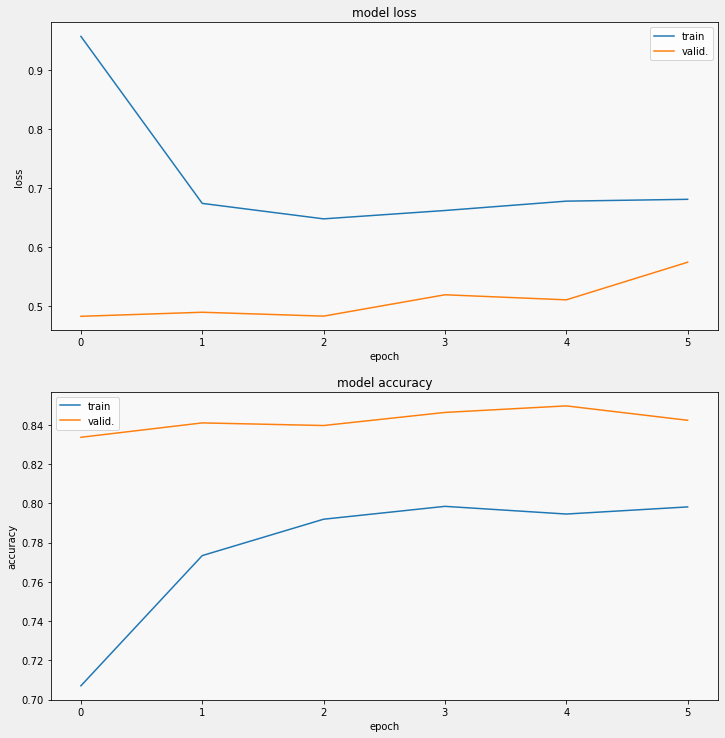

In [43]:
# plot for VGG19
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

# EfficientNetB7

optimizer: Adam

loss: categorical_smooth_loss (refer the function def)

In [44]:
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(6, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

258072576/258068648 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 64)   1728        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 64)   0           stem_bn[0][0]                    
_________________________

In [45]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)

Epoch 1/15
878/878 [==============================] - 102s 116ms/step - loss: 1.6626 - accuracy: 0.3114 - val_loss: 1.6090 - val_accuracy: 0.4930 - lr: 1.0000e-04
Epoch 2/15
878/878 [==============================] - 96s 109ms/step - loss: 1.5047 - accuracy: 0.4007 - val_loss: 1.4852 - val_accuracy: 0.3823 - lr: 1.0000e-04
Epoch 3/15
878/878 [==============================] - ETA: 0s - loss: 1.4420 - accuracy: 0.4497
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
878/878 [==============================] - 95s 108ms/step - loss: 1.4420 - accuracy: 0.4497 - val_loss: 1.5055 - val_accuracy: 0.6403 - lr: 1.0000e-04
Epoch 4/15
878/878 [==============================] - 95s 108ms/step - loss: 1.3621 - accuracy: 0.4917 - val_loss: 1.2041 - val_accuracy: 0.7317 - lr: 3.0000e-05
Epoch 5/15
878/878 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.5321
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
878/878 [

The EfficientNetB7 did not work well for us.

# DenseNet121

optimizer: RMSprop
loss: categorical_smooth_loss

Densenet has many variants, let us see if Densenet121 works better than Densenet201, here we are training the last 3 layers too, this totally depends on the problem that is to be solved. 

In [46]:
#try3
pretrained_densenet = tf.keras.applications.DenseNet121(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers[:-3]:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(6, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
___________________________

In [47]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[checkpoint,lr_reduce, es_callback], epochs=20)

Epoch 1/20
878/878 [==============================] - 79s 90ms/step - loss: 1.1035 - accuracy: 0.7160 - val_loss: 0.7248 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 2/20
878/878 [==============================] - 77s 88ms/step - loss: 0.9384 - accuracy: 0.7916 - val_loss: 0.6874 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 3/20
878/878 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.8063
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
878/878 [==============================] - 77s 88ms/step - loss: 0.9022 - accuracy: 0.8063 - val_loss: 0.6644 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 4/20
878/878 [==============================] - 77s 88ms/step - loss: 0.8428 - accuracy: 0.8380 - val_loss: 0.6506 - val_accuracy: 0.9023 - lr: 3.0000e-04
Epoch 5/20
878/878 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.8454
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
878/878 [==================

### Lets try another variant of DenseNet

# DenseNet201

optimizer: RmsProp

loss: categorical_smooth_loss

In [48]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(6, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 3s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 134, 134, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
___________________________

In [49]:
#try2 -> with RMSprop
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)

Epoch 1/15
878/878 [==============================] - 87s 99ms/step - loss: 0.9928 - accuracy: 0.7540 - val_loss: 0.6972 - val_accuracy: 0.8903 - lr: 1.0000e-04
Epoch 2/15
878/878 [==============================] - 84s 95ms/step - loss: 0.8432 - accuracy: 0.8384 - val_loss: 0.6651 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 3/15
878/878 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.8576
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
878/878 [==============================] - 85s 97ms/step - loss: 0.8038 - accuracy: 0.8576 - val_loss: 0.6534 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 4/15
878/878 [==============================] - 83s 95ms/step - loss: 0.7795 - accuracy: 0.8686 - val_loss: 0.6489 - val_accuracy: 0.9053 - lr: 3.0000e-05
Epoch 5/15
878/878 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.8753
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
878/878 [=====

It seems like 15 epoch is not sufficient and we can get better results with a few more, if we want to increase the number of epochs, we just fit the same model again with the number of epochs, it will continue from the last epoch. 

above we trained till 15, now we execute a copy of the cell, with 5 epochs, observe that the model is still using what it learned and resumes the training.

In [50]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=5)

Epoch 1/5
878/878 [==============================] - 82s 93ms/step - loss: 0.7517 - accuracy: 0.8839 - val_loss: 0.6440 - val_accuracy: 0.9077 - lr: 7.2900e-08
Epoch 2/5
878/878 [==============================] - 83s 94ms/step - loss: 0.7553 - accuracy: 0.8809 - val_loss: 0.6439 - val_accuracy: 0.9073 - lr: 7.2900e-08
Epoch 3/5
878/878 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.8808
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.1869998079182552e-08.
878/878 [==============================] - 82s 93ms/step - loss: 0.7541 - accuracy: 0.8808 - val_loss: 0.6439 - val_accuracy: 0.9077 - lr: 7.2900e-08
Epoch 4/5
878/878 [==============================] - 82s 93ms/step - loss: 0.7518 - accuracy: 0.8836 - val_loss: 0.6439 - val_accuracy: 0.9073 - lr: 2.1870e-08
Epoch 5/5
878/878 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.8836
Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.560999210591944e-09.
878/878 [==========

# BEST MODEL

# DenseNet201

optimizer: Adam

loss: categorical_smooth_loss

In [51]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(6, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

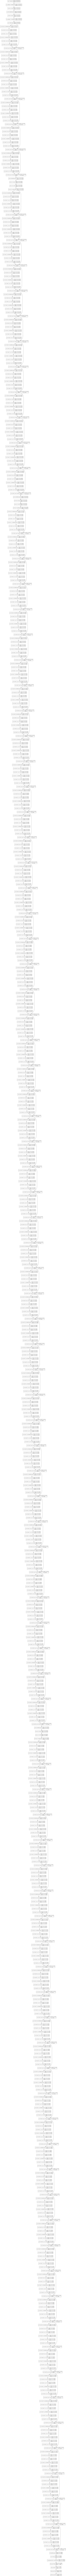

In [52]:
plot_model(model_densenet, show_shapes=True, to_file='model_densenet.png')

In [53]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)

Epoch 1/15
878/878 [==============================] - 87s 99ms/step - loss: 1.0106 - accuracy: 0.7381 - val_loss: 0.7154 - val_accuracy: 0.8810 - lr: 1.0000e-04
Epoch 2/15
878/878 [==============================] - 82s 94ms/step - loss: 0.8395 - accuracy: 0.8375 - val_loss: 0.6819 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 3/15
878/878 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.8563
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
878/878 [==============================] - 82s 93ms/step - loss: 0.8075 - accuracy: 0.8563 - val_loss: 0.6712 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/15
878/878 [==============================] - 82s 93ms/step - loss: 0.7800 - accuracy: 0.8687 - val_loss: 0.6625 - val_accuracy: 0.9053 - lr: 3.0000e-05
Epoch 5/15
878/878 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.8754
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
878/878 [=====

This function can be used to plot the loss and accuracy of any model, I am not plotting this for all of the models but feel free to plot them to visualize the loss and accuracy.

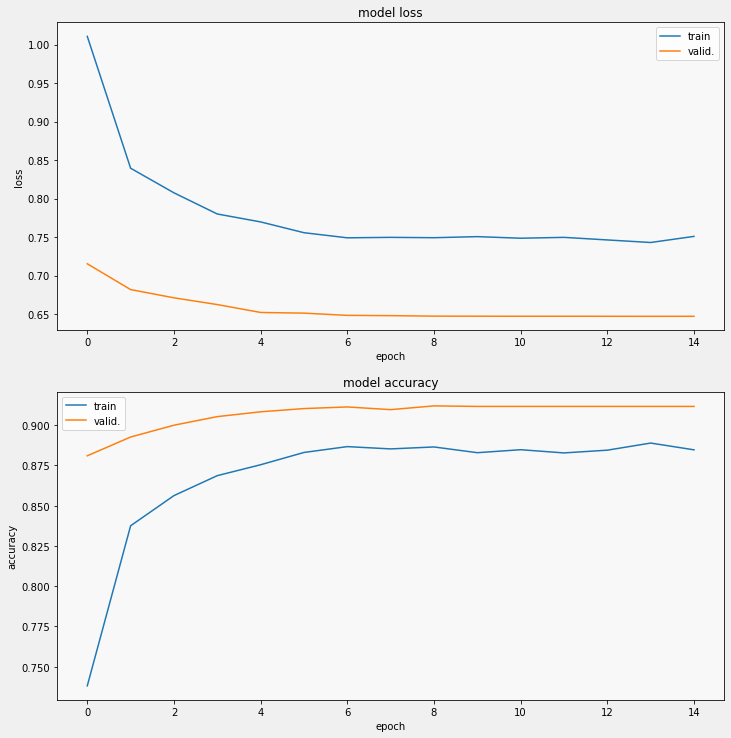

In [54]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

In [55]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

### We can take any test image

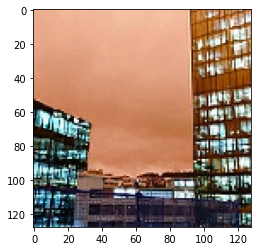

In [56]:
# test image
file_path =  '../input/intel-image-classification/seg_test/seg_test/buildings/20064.jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (128,128),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

### see what the prediction is

In [57]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as sea


Heatmaps are useful in some cases to identify what the classifier has learnt, but it is a bit difficult to interpret.

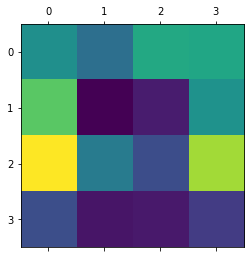

In [58]:
plt.matshow(heatmap)
plt.show()

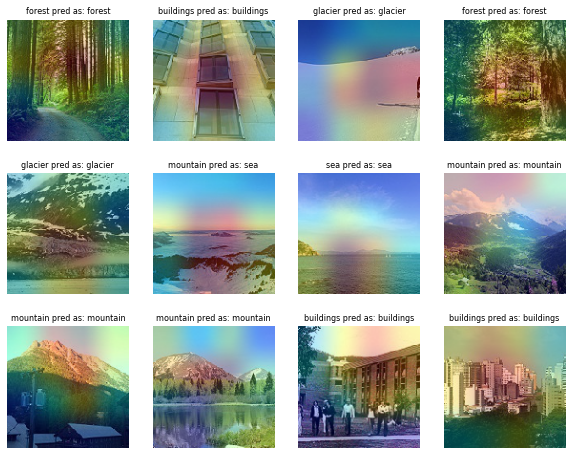

In [59]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

### It can be seen that DenseNet201 has done a pretty good job in classifying them
